In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Graphs: **TensorFlow Backend**
This notebook shows how define and evaluate kernels on a simple graph.
By this we mean kernels $k: V \times V \to \mathbb{R}$ where $V$ is a vertex set of a graph.
The graph **must be** undirected and have nonnegative weights.
The edges of this graph define the geometry: you expect that nodes connected by edges with large weights to be more correlated than nodes connected by edges with small weights.

At the very end of the notebook we also show how to construct *approximate finite-dimensional feature maps* for the kernels on graphs and how to use these to efficiently sample the Gaussian processes $\mathrm{GP}(0, k)$.

We use the **TensorFlow** backend here.

**Important:** if you want to model a **signal on the edges** of a graph $G$, you can consider modeling the signal on the nodes of the [line graph](https://en.wikipedia.org/wiki/Line_graph). The line graph of $G$ has a node for each edge of $G$ and its two nodes are connected by an edge if the corresponding edges in $G$ used to share a common node. To build the line graph, you can use the [line_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.line.line_graph.html#line-graph) function of `networkx`. Alternatively, especially for the flow-type data, you might want to use specialized edge kernels, see [Yang et al. (2023)](https://arxiv.org/abs/2310.19450) and [Alain et al. (2023)](https://arxiv.org/abs/2311.01198>).
These are not implemented in GeometricKernels at the moment.


In [2]:
# Import a backend, we use jax in this example.
import tensorflow as tf

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels import MaternGeometricKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO: Using numpy backend


## Defining a Space

First we create and visualize a simple *star graph* using `networkx`

In [3]:
nx_graph = nx.star_graph(6)

Define graph layout to reuse it later on (so that graph appears the same on all pictures).

In [4]:
pos = nx.spring_layout(nx_graph)

Visualize the graph.

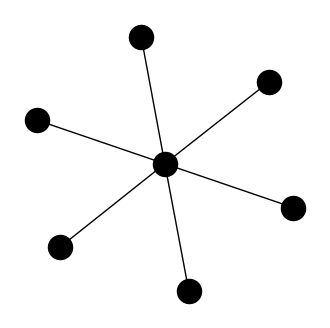

In [5]:
plt.figure(figsize=(4,4))
nx.draw(nx_graph, node_color = 'black', ax=plt.gca(), pos=pos)
plt.show()

The following cell turns the `nx_graph` created above into a GeometricKernels `Graph` space.

The `normalize_laplacian` parameter controls whether to use the eigenvectors
of the *unnormalized Laplacian* or the *symmetric normalized Laplacian* as
features (see the optional Theory section below for details).
You may want to try both `normalize_laplacian=False` and `normalize_laplacian=True` for your task.
The former is the default.

In [6]:
graph = Graph(tf.convert_to_tensor(nx.to_numpy_array(nx_graph), dtype=tf.float64), normalize_laplacian=False)

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `graph` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on graphs can be found on this [documentation page](https://gpflow.github.io/GeometricKernels/theory/graphs.html).

In [7]:
kernel = MaternGeometricKernel(graph)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [8]:
params = kernel.init_params()
print('params:', params)

params: {'lengthscale': array(1.), 'nu': array(inf)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params` we define below.

**Note:** unlike the Euclidean or the manifold case, the $1/2, 3/2, 5/2$ may fail to be the reasonable values of $\nu$.
On the other hand, the parameter $\nu$ is optimizable in the same way in which the legnthscale is.
Keep in mind though, that the optimization problem may require finding some trial and error to find good a initialization and that reasonable $\kappa$ and $\nu$ will heavily depend on the specific graph in a way that is hard to predict.

**Note:** consider a graph with the scaled adjacency $\mathbf{A}' = \alpha^2 \mathbf{A}$, for some $\alpha > 0$.
Denote the kernel corresponding to $\mathbf{A}$ by $k_{\nu, \kappa}$ and the kernel corresponding to $\mathbf{A}'$ by $k_{\nu, \kappa}'$.
Then, as apparent from [the theory](https://gpflow.github.io/GeometricKernels/theory/graphs.html), for the normalized graph Laplacian we have $k_{\nu, \kappa}' (i, j) = k_{\nu, \kappa} (i, j)$.
On the other hand, for the unnormalized graph Laplacian, we have $k_{\nu, \kappa}' (i, j) = k_{\nu, \alpha \cdot \kappa} (i, j)$, i.e. the lengthscale changes.

In [9]:
from numpy import inf
params["lengthscale"] = tf.convert_to_tensor([2.0], dtype=tf.float64)
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = tf.convert_to_tensor([3/2], dtype=tf.float64)
params_inf["nu"] = tf.convert_to_tensor([inf], dtype=tf.float64)

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `3` (uniformly) random points on our graph.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [10]:
key = tf.random.Generator.from_seed(1234)

key, xs = graph.random(key, 3)

print(xs)

tf.Tensor(
[[3]
 [2]
 [0]], shape=(3, 1), dtype=int32)


Now we evaluate the two kernel matrices.

In [11]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

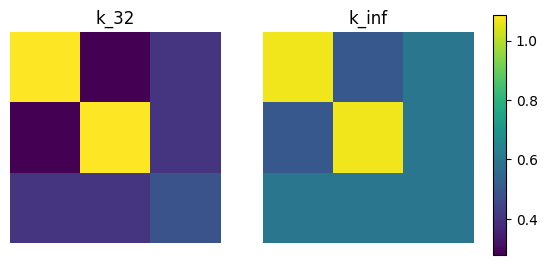

In [12]:
# find common range of values
minmin = min(tf.math.reduce_min(kernel_mat_32), tf.math.reduce_min(kernel_mat_inf))
maxmax = max(tf.math.reduce_max(kernel_mat_32), tf.math.reduce_max(kernel_mat_inf))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

Here we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We define `base_point` and `other_points` in the next cell.

In [13]:
base_point = 1 # choosing a fixed node for kernel visualization
other_points = tf.range(graph.num_vertices)[:, None]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [14]:
values_32  = tf.reshape(kernel.K(params_32,  tf.convert_to_tensor([[base_point]]),
                              other_points), [-1])
values_inf = tf.reshape(kernel.K(params_inf, tf.convert_to_tensor([[base_point]]),
                              other_points), [-1])

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [15]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = kernel.K_diag(params_32,  other_points)
variance_inf = kernel.K_diag(params_inf, other_points)

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_point, *)` where `*` goes through all nodes and `base_point` has red outline. 

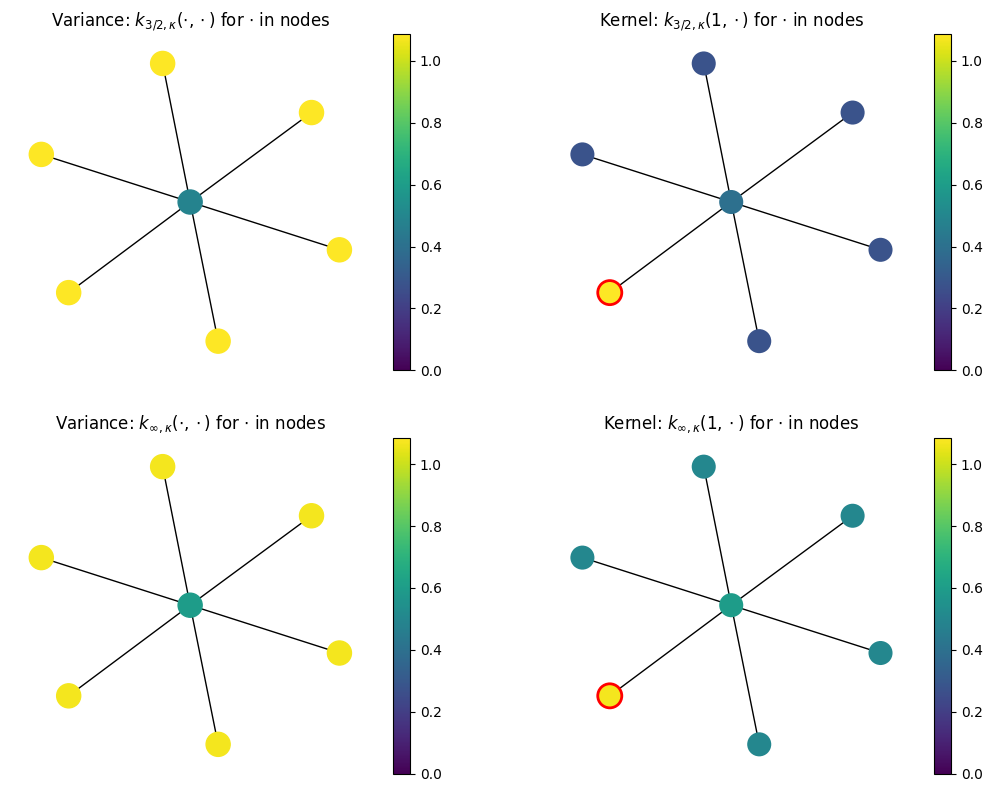

In [16]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(0.0, tf.math.reduce_min(values_32), tf.math.reduce_min(values_inf))
vmax = max(1.0, tf.math.reduce_max(variance_32), tf.math.reduce_max(variance_inf))


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=variance_32,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: $k_{3/2, \kappa}(\cdot, \cdot)$ for $\cdot$ in nodes')

# Plot kernel values 32
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot variance inf
nx.draw(nx_graph, ax=ax3, cmap=cmap, node_color=variance_inf,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Variance: $k_{\infty, \kappa}(\cdot, \cdot)$ for $\cdot$ in nodes')

# Plot kernel values inf
nx.draw(nx_graph, ax=ax4, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

## A Note on Prior Variance

Note that the **variance changes from node to node** on this graph.

For example, for the **unnormalized Laplacian**, the variance is related to the expected *return time of a random walk*: how many steps, on average, does it take a particle
randomly walking over the graph and starting in node x to return back to node x.
For the center node, the expected return time is 2.
For other nodes, it is always higher.
Hence the variance in the center is *lower* than in the other nodes.
This argument is inspired by [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2010.15538.pdf).

For the **symmetric normalized Laplacian** the situation is different.

See this [Jupyter notebook](https://github.com/spbu-math-cs/Graph-Gaussian-Processes/blob/main/examples/graph_variance.ipynb) for more examples of how variance differs for different graphs.

In [17]:
print('Variance in the center node is %0.2f,' % variance_32[0],
      'variance in the side nodes is %0.2f.' % variance_32[1],
      'The average variance is %0.2f.' % tf.reduce_mean(variance_32))

Variance in the center node is 0.49, variance in the side nodes is 1.09. The average variance is 1.00.


# Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on graphs, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [18]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For graphs, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `Graph` space, the first element is `None` since the feature map is *deterministic*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [19]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = tf.matmul(embedding, tf.transpose(embedding))

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', tf.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (3, 1)):
tf.Tensor(
[[3]
 [2]
 [0]], shape=(3, 1), dtype=int32)

emedding (shape = (3, 7)):
tf.Tensor(
[[-0.64111333 -0.10633366  0.79213149 -0.10633366 -0.10633366 -0.10633366
  -0.04541286]
 [-0.64111333  0.79213149 -0.10633366 -0.10633366 -0.10633366 -0.10633366
  -0.04541286]
 [-0.64111333  0.          0.          0.          0.          0.
   0.27247716]], shape=(3, 7), dtype=float64)

||k(xs, xs) - phi(xs) * phi(xs)^T|| = tf.Tensor(0.0, shape=(), dtype=float64)


## Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [20]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = tf.random.Generator.from_seed(1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
tf.Tensor(
[[ 0.1415026   0.59316153]
 [-0.82157238  0.28214162]
 [-0.01065247  0.76162598]], shape=(3, 2), dtype=float64)


### Visualizing Samples
Here we visualize samples as functions on a graph.

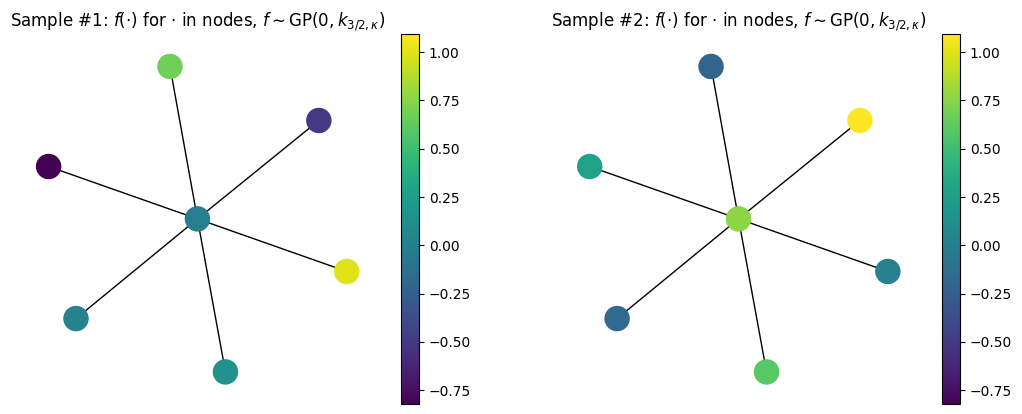

In [21]:
key = tf.random.Generator.from_seed(1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(tf.math.reduce_min(sample1), tf.math.reduce_min(sample2))
vmax = max(tf.math.reduce_max(sample1), tf.math.reduce_max(sample2))

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

# Plot sample #1
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=sample1,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Plot sample #2
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=sample2,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

plt.show()

# Citation

If you are using graphs and GeometricKernels, please consider citing

```
@article{borovitskiy2020,
    title={Matern Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}}
```

```
@inproceedings{kondor2002,
  title={Diffusion Kernels on Graphs and Other Discrete Structures},
  author={Kondor, Risi Imre and Lafferty, John},
  booktitle={International Conference on Machine Learning},
  year={2002}}
```